## Attention:

Maybe the kernel has to be restarted. (Kernel-> Restart Kernel)

In [2]:
%pip install numpy scipy pandas matplotlib

    100% |████████████████████████████████| 17.2MB 60kB/s 
    100% |████████████████████████████████| 24.7MB 47kB/s 
    100% |████████████████████████████████| 10.0MB 111kB/s 
    100% |████████████████████████████████| 13.0MB 90kB/s 
    100% |████████████████████████████████| 512kB 1.9MB/s 
    100% |████████████████████████████████| 235kB 5.2MB/s 
    100% |████████████████████████████████| 952kB 957kB/s 
    100% |████████████████████████████████| 71kB 4.3MB/s 
    100% |████████████████████████████████| 583kB 658kB/s 
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import euclidean, squareform
import math
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix
import time
import sys
sys.setrecursionlimit(150000)
%matplotlib inline

define functions for clustering the correlation Matrix and plot it

In [2]:
def cluster_correlation_matrix(correlation_matrix, headers=None, threshold=0.1, how="average"):
    monitoring_features = [i for i in range(correlation_matrix.shape[0]) if np.isnan(correlation_matrix[i][i])]
    features_to_cluster = [i for i in range(correlation_matrix.shape[0]) if i not in monitoring_features]
    # clean up np.nans by filling them with 0
    correlation_matrix = np.nan_to_num(correlation_matrix)
    # As distance measure we will use the already computed correlation between 2 columns.
    d = [np.abs(1-np.abs(correlation_matrix[i, j]))
         for i in range(0, len(correlation_matrix))
         for j in range(i+1, len(correlation_matrix))]
    distance_matrix = squareform(d)
    # choose the correct distances from the distance matrix
    distances = []
    for i in range(0, len(features_to_cluster)):
        for j in range(i+1, len(features_to_cluster)):
            distances.append(distance_matrix[features_to_cluster[i], features_to_cluster[j]])
    distances = np.asarray(distances)
    # check if distance list is empty
    if len(distances) > 0:
        # hierarchical clustering created with distance measure specialized by "how"
        hierarchical = sch.linkage(distances, method=how)
        # use fcluster to find clusters out of hierarchical clustering structure with a min distance threshold
        value = threshold
        ind = sch.fcluster(hierarchical, value, criterion='distance')
        # determine cluster indices
        clustered_list = [[features_to_cluster[j] for j in np.where(ind == i)[0]] for i in np.unique(ind)]
    clustered_list.append(monitoring_features) 
    centres = []
    for index in clustered_list:
        temp = []
        for k in index:
            temp.append(correlation_matrix[k])
        centres.append(np.mean(temp, axis=0).tolist())

    columns = [i for items in clustered_list for i in items]
    clustered_correlation_matrix = np.asarray([[correlation_matrix[v][x] for x in columns] for v in columns])
    features = []
    # find nearest feature vectors to the cluster centres
    for index, i in zip(clustered_list, range(len(centres))):
        d = []
        for point in correlation_matrix[index]:
            d.append(euclidean(centres[i], point))
        sort = np.argsort(d)
        temp = []
        for j in range(0):
            temp.append(index[sort[j]])
        if headers is None:
            features.append(np.asarray(temp))
        else:
            features.append([headers[i] for i in temp])

    # finally map headers to clusters if headers are defined
    if headers is not None:
        clustered_headers = []
        for k in range(len(clustered_list)):
            clustered_headers.append([headers[i] for i in clustered_list[k]])
        return clustered_correlation_matrix, features, clustered_headers
    else:
        return clustered_correlation_matrix, features, clustered_list
def plot_correlation_matrix(correlation_matrix, headers, filename="default.pdf"):
    # standard setting of matrix plot
    f = plt.figure()
    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
    plt.imshow(correlation_matrix)
    # check if the matrix is already clustered, by asking for the behavior of the headers. if headers is a nested list,
    # this means, the matrix is already clustered
    if isinstance(headers[0], list):    # => matrix is clusterd
        print("headers is nesetd list")
        total_old = -0.5    # since in imshow the mid of the first rectangle starts at (0,0)
        for i in range(len(headers)):
            total_new = len(headers[i])
            plt.gca().add_patch(plt.Rectangle((total_old, total_old), total_new, total_new,
                                              ec='r', fill=False, linewidth=3))
            total_old = total_old + total_new
        headers = [item for sublist in headers for item in sublist]
    plt.xticks(range(len(headers)), headers, rotation='vertical')
    plt.yticks(range(len(headers)), headers)
    plt.colorbar()
    plt.show()
    # to save it f=plt.figure()
    # ...ploting stuff
    f.savefig(filename, bbox_inches='tight')
    return

# small test data
#smallMatrix = np.array([[np.nan, np.nan,np.nan,np.nan, np.nan,np.nan],[np.nan, 1.0, 0.7,   0.2, 0.1, 0.1], [np.nan,0.7, 1.0,  0.15, 0.2, 0.11], [np.nan,0.2, 0.15,  1.0, 0.99, 0.96], [np.nan,0.1, 0.2,  0.99, 1.0, 0.96],[np.nan,0.1, 0.11, 0.96, 0.96, 1.0]]) 
#plot_correlation_matrix(smallMatrix, list(range(smallMatrix.shape[0])))
#clustered_matrixSmall,featuresSmall,clustersSmall = cluster_correlation_matrix(smallMatrix, headers=None, threshold=0.9, how="complete")
#plot_correlation_matrix(clustered_matrixSmall, clustersSmall)

# Initialize Spark and load data

In [3]:
# Spark stuff
import findspark
import pyspark
from pyspark.sql.types import *
spark = pyspark.sql.SparkSession\
       .builder\
       .appName("PySparkClusterCorrelationDemo")\
       .config("spark.cores.max", "8")\
       .config("spark.driver.maxResultSize", "2g")\
       .getOrCreate()

In [5]:
context = spark.sparkContext
folder_results ="/demo/results/correlationMatrix.txt"
correlationMatrixRawRDD = context.textFile(folder_results)


We load the correlation matrix from HDFS as a coordinate Matrix

In [6]:
values = correlationMatrixRawRDD.map(lambda row: float(row.replace("(","").replace(")","").split(",")[2])).collect()
x = correlationMatrixRawRDD.map(lambda row: int(row.replace("(","").replace(")","").split(",")[0])).collect()
y = correlationMatrixRawRDD.map(lambda row: int(row.replace("(","").replace(")","").split(",")[1])).collect()

In [7]:
size = int(np.sqrt(len(x)))
matrix = np.zeros([size,size])
matrix[x,y] = values

# Plot correlation matrix (not clustered)

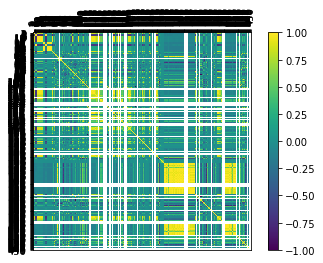

In [8]:
plot_correlation_matrix(matrix, list(range(matrix.shape[0])))

# Cluster correlation matrix

In [9]:
clustered_matrix,features,clusters = cluster_correlation_matrix(matrix, threshold=0.5, how="complete")

headers is nesetd list


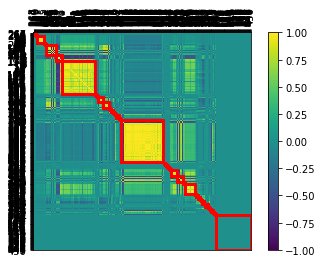

In [10]:
plot_correlation_matrix(clustered_matrix, clusters, "clusteredCorrelationMatrix.pdf")

In [11]:
print("Anzahl an Cluster", len(clusters))


Anzahl an Cluster 74


In [14]:
# welche Spalten sind in den Clustern
#clusters